## Load the weights file into model package

This is tested on a notebook instances. conda_pytorch_p310 kernel

In [7]:
import sagemaker
import boto3
import time
import json
from io import BytesIO
import base64
from PIL import Image
import shutil

from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

s3_prefix = (
    "SDXL-dreambooth"  # folder within bucket where code artifact will go
)

region = sess._region_name
account_id = sess.account_id()
mme_prefix = f"{s3_prefix}/inference/models"

model_data_url = f"s3://{bucket}/{mme_prefix}/"

# uncomment if you want to set this folder name yourself
# project_name = "finetune_jingswu" # this is the location of your LoRA weights
%store -r project_name # this requires you to run the finetuning notebook first

Copy the loRA weights into the `model_dir` and the model folder. We will use this to build the model package group.

In [6]:
model_repo = "model_dir"

model_name = "jingswu"
lora_weights = f"{project_name}/pytorch_lora_weights.safetensors"

dest_dir = f"{model_repo}/{model_name}/1"

shutil.copy(lora_weights, dest_dir)

'model_dir/jingswu/1/pytorch_lora_weights.safetensors'

Create the tar file

In [8]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [9]:
tar_name = f"{model_name}.tar.gz"
!tar -C $model_repo -czvf $tar_name $model_name

sess.upload_data(path=tar_name, bucket=bucket, key_prefix=mme_prefix)
!rm $tar_name

jingswu/
jingswu/config.pbtxt
jingswu/1/
jingswu/1/model.py
jingswu/1/pytorch_lora_weights.safetensors


## Deploy endpoint
Now, you get the customer container url

In [10]:
%store -r extended_triton_image_uri

you are now ready to configure and deploy the multi-model endpoint

In [11]:
sm_client = boto3.client(service_name="sagemaker")

container = {
    "Image": extended_triton_image_uri,
    "ModelDataUrl": model_data_url, #f"{model_data_url}{tar_name}",     # S3 location of the models
#     "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "jingswu"}
    "Mode": "MultiModel",
}

In [12]:
sm_model_name = name_from_base(f"{mme_prefix.split('/')[0]}-models")

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:122702569249:model/sdxl-dreambooth-models-2024-03-17-13-12-39-642


Create a SageMaker endpoint configuration.

In [13]:
endpoint_config_name = f"{sm_model_name}-epc"

instance_type = 'ml.g5.2xlarge'

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 2,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:122702569249:endpoint-config/sdxl-dreambooth-models-2024-03-17-13-12-39-642-epc


Create the endpoint, and wait for it to transition to InService state. (This takes about 10 mins)

In [16]:
endpoint_name = f"{sm_model_name}-endpoint"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:122702569249:endpoint/sdxl-dreambooth-models-2024-03-17-13-12-39-642-endpoint
Status: InService


## Setup AutoScaling Policy (Optional)
This section describes how to configure autoscaling on your asynchronous endpoint using Application Autoscaling. You need to first register your endpoint variant with Application Autoscaling, define a scaling policy.

In [18]:
client = boto3.client(
    "application-autoscaling"
)  # Common class representing Application Auto Scaling for SageMaker amongst other services

resource_id = (
    "endpoint/" + endpoint_name + "/variant/" + "AllTraffic"
)  # This is the format in which application autoscaling references the endpoint

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=2,
    MaxCapacity=5,
)

response = client.put_scaling_policy(
    PolicyName=f"{sm_model_name}-invoc-scaling",
    ServiceNamespace="sagemaker",  # The namespace of the AWS service that provides the resource.
    ResourceId=resource_id,  # Endpoint name
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="TargetTrackingScaling",  # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 5.0,  # The target value for the metric. - here the metric is - SageMakerVariantInvocationsPerInstance
        "CustomizedMetricSpecification": {
            "MetricName": "ApproximateBacklogSizePerInstance",
            "Namespace": "AWS/SageMaker",
            "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
            "Statistic": "Average",
        },
        "ScaleInCooldown": 600,  # The cooldown period helps you prevent your Auto Scaling group from launching or terminating
        # additional instances before the effects of previous activities are visible.
        # You can configure the length of time based on your instance startup time or other application needs.
        # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start.
        "ScaleOutCooldown": 300  # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.
        # 'DisableScaleIn': True|False - ndicates whether scale in by the target tracking policy is disabled.
        # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
    },
)

## Invoke the LoRA fine tuned model

In [19]:
sm_runtime = boto3.client("sagemaker-runtime")

In [20]:
# helper functions to encode and decode images
def decode_image(img):
    buff = BytesIO(base64.b64decode(img.encode("utf8")))
    image = Image.open(buff)
    return image

In [23]:
prompt = """photo of <<TOK>>, epic front portrait, wearing glasses, handsome, in astronaut suit exploring the cosmos, floating among planets and stars, high quality detail, anime screencap, studio ghibli style, illustration, high contrast, masterpiece, best quality"""
negative_prompt = """ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
watermark, grainy, signature, cut off, draft, amateur, multiple, gross, weird, uneven, furnishing, decorating, decoration, furniture, text, poor, low, basic, worst, juvenile, 
unprofessional, failure, crayon, oil, label, thousand hands"""

In [ ]:
prompt = """photo of <<TOK>>, epic front portrait, with glasses, zoom in, suit and tie, young and handsome, symmetry, blured background, futuristic cityscape"""

In [ ]:
prompt = """photo of <<TOK>>, with glasses, cute modern disney style, Pixar 3d portrait, ultra detailed, gorgeous, 3d zbrush, trending on dribbble, 8k render"""

In [28]:
import random

seed = random.randint(1, 1000000000)
gen_args = json.dumps(dict(num_inference_steps=50, guidance_scale=7, height=1024, width=1024, seed=seed))

inputs = dict(prompt = prompt,
              negative_prompt = negative_prompt,
              gen_args = gen_args)

payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

CPU times: user 4.76 ms, sys: 161 µs, total: 4.92 ms
Wall time: 17.9 s


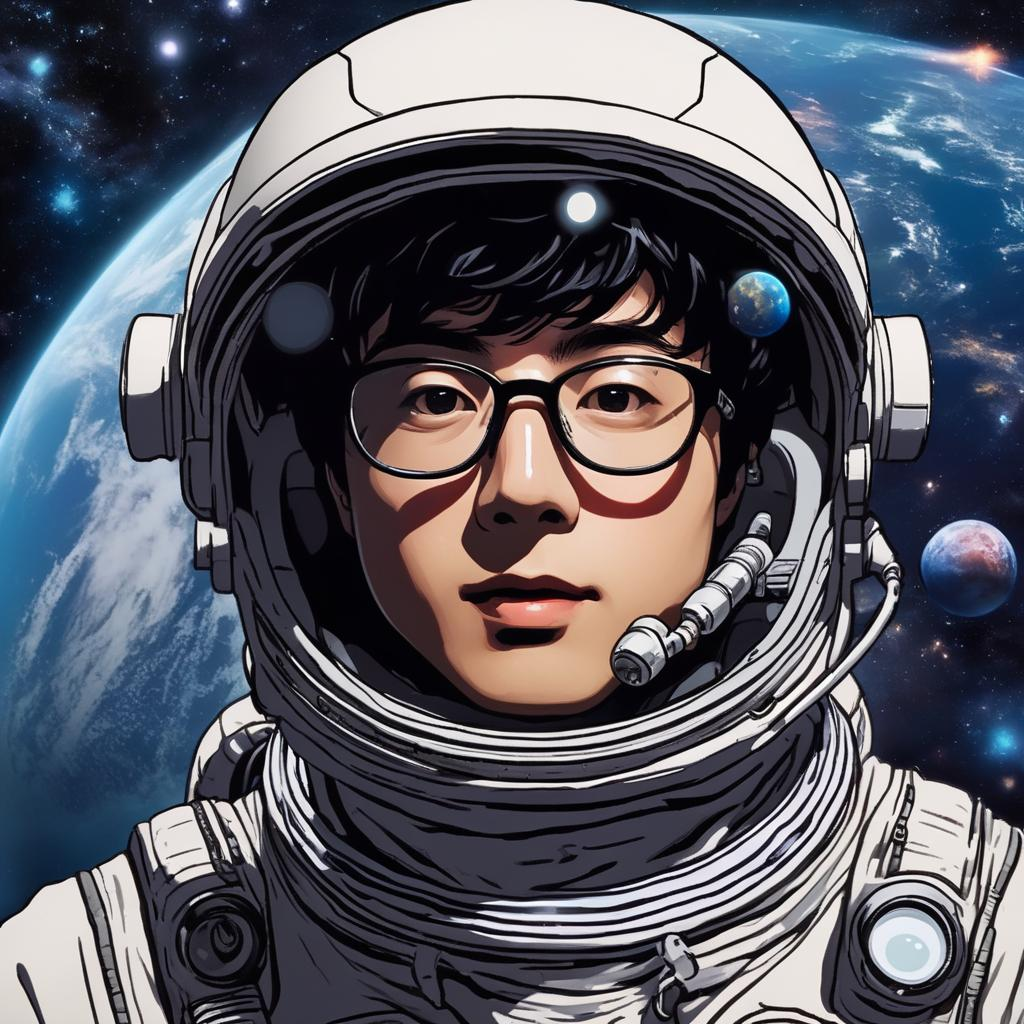

In [29]:
%%time
response = sm_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel=tar_name,
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
original_image = decode_image(output[0]["data"][0])
original_image

## Clean Up

In [ ]:
# sm_client.delete_endpoint(EndpointName=endpoint_name)
# sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
# sm_client.delete_model(ModelName=sm_model_name)